# Analyzing the Capacity of SOMs to clear outliers

In this notebook, we're going to analyze how SOms can identify outliers in the dataset and then, reduce the rate of the false alarms.

In [1]:
import warnings
import pandas as pd
from modules.som_detector import SOM_outlier_detector
from modules.anomaly_detector import AnomalyDetectionKit

# ignore warnings
warnings.filterwarnings('ignore')

In [2]:
# load data
x = pd.read_csv('../0_data/som_studies/normal_operation_compressor.csv',
                index_col=[0])
x.head()

,FCV-501D_ACT,PIT-501D,PIT-516D,PIT-517D,PIT-518D,PIT-519D,PIT-521D,PIT-523D,PIT-529D,PIT-530D,...,XT-506D-X,XT-506D-Y,XT-507D-X,XT-507D-Y,XT-508D-X,XT-508D-Y,ZT-503D-A,ZT-503D-B,ZT-504D-B,ZY-503D
0,45.493362,40.756344,20.902378,17.372452,2.038123,2.224318,0.992395,3.347148,4.506837,5.060158,...,13.370263,11.907991,8.478170,9.437210,6.986217,10.068040,26.280346,26.706827,0.071125,26.317259
1,44.839832,40.872658,20.552832,17.094263,2.000226,2.184674,0.992454,3.304876,4.491679,5.077046,...,13.718800,12.062502,8.429724,9.592444,7.121663,10.251029,26.943079,27.212057,0.071125,26.810747
2,47.116543,40.626442,21.869236,18.119350,2.124781,2.319191,0.991775,3.460335,4.479621,5.148957,...,13.031363,11.878652,8.444281,9.146814,6.753309,9.941579,24.002470,24.779950,0.074429,24.078333
3,47.255856,40.635143,21.998035,18.240286,2.147179,2.343245,0.991836,3.480938,4.429873,5.161973,...,13.584080,12.130912,8.444281,9.146688,6.811512,10.018728,23.825638,24.554980,0.075468,23.965624
4,47.097378,40.642517,21.893854,18.163750,2.138274,2.335860,0.991764,3.471886,4.563508,5.125422,...,13.545857,12.169901,8.458838,9.292214,6.772871,10.038246,23.996452,24.678562,0.071191,24.140740


In [3]:
# fit som
sod = SOM_outlier_detector()
sod.fit_som(x, n=10)

In [4]:
# identify outliers
out_idx = sod.identify_anomalies(x)

In [5]:
# remove the identified outliers
x = x.loc[~x.index.isin(out_idx), :]

# reset the index
x.reset_index(drop=True, inplace=True)

Parallel Method Results
--------------------------------------------------
Number of PCs retained: 9
Explained Variance: 90.59 %


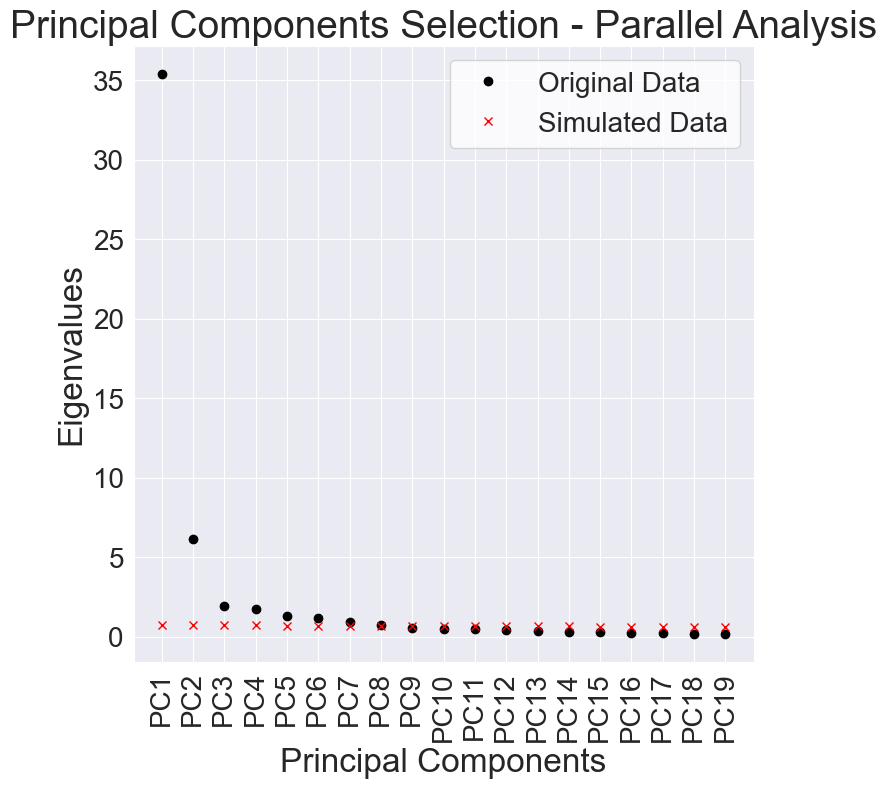

In [6]:
# create class of anomaly detection kit
adk = AnomalyDetectionKit()

# apply the parallel method
adk.parallel_analysis(x, plot=True)

In [7]:
# fit the final PCA
adk.fit_final(x, n=8)
adk.save_model(adk.final_pca, 'SOM10_n1')

Number of PCs changed
--------------------------------------------------
Number of PCs retained: 8
Explained Variance: 89.56 %


In [8]:
# calculate Hotellings T2s and critical value
t2s, tmax = adk.calculate_T2(data=x)

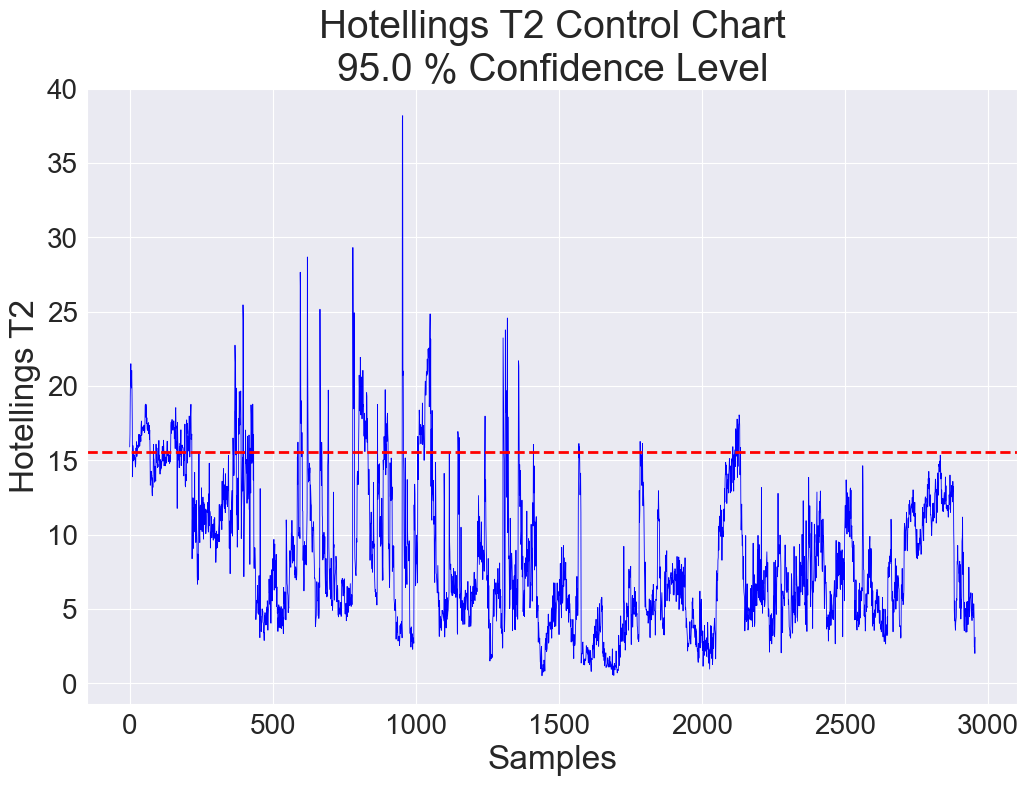

In [9]:
# build control chart - baseline - T2s
fig = adk.build_control_charts(values=t2s, limits=tmax,
                         chart_title='Hotellings T2')
fig.show()

In [10]:
# calculate SPE and critical value
spe, spe_max = adk.calculate_SPE(data=x)

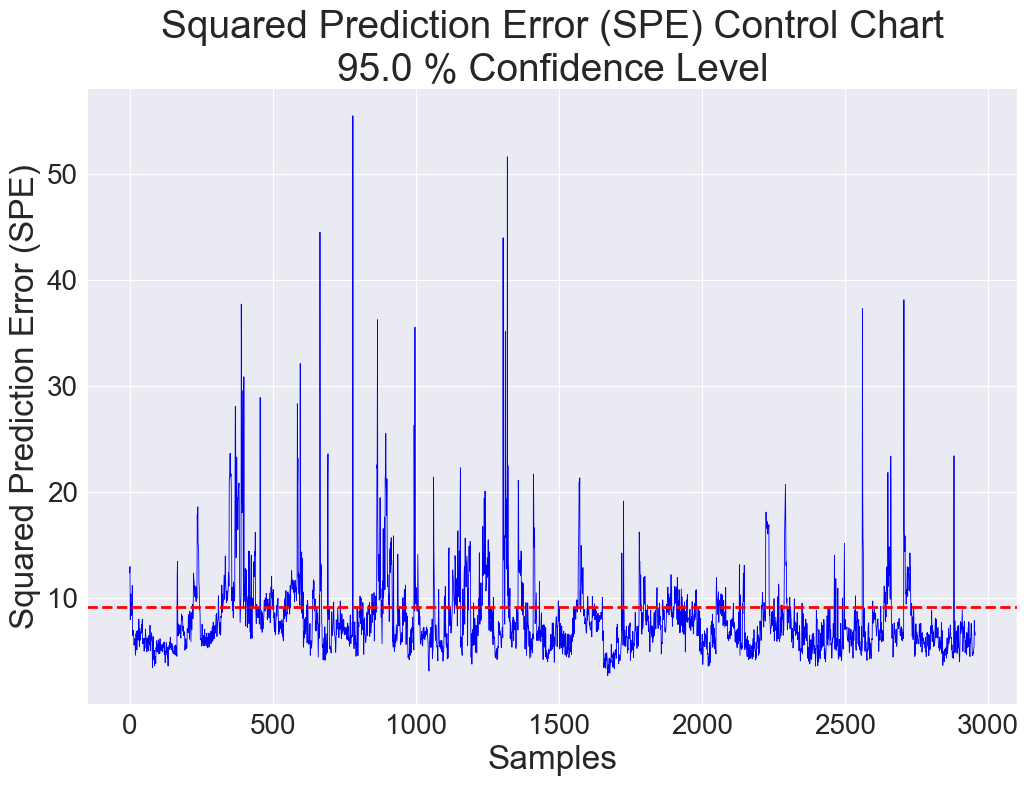

In [11]:
# build control chart - baseline - SPE
fig = adk.build_control_charts(values=spe, limits=spe_max,
                         chart_title='Squared Prediction Error (SPE)')
fig.show()

In [12]:
# join all statistics
data_stats = pd.DataFrame(t2s, columns=['t2'])
data_stats['spe'] = spe
adk.calculate_metrics(data_stats=data_stats, 
                      limits=[tmax, spe_max])

(0.10554803788903924, 0.229702300405954, 0.029093369418132613)

- interesting observation: the application of the SOM to identify outliers increased the false negative rates.
- why?
    - changes in the multivariante mean? -> effect in the Hotellings T2
    - changes in the eigenvalues and variance distribution? -> effect in the SPE